In [1]:
import os
import json
import numpy as np
from astropy.table import Table, join, vstack, setdiff
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

DRPVER = "1.2.0"

#sas = os.environ['SAS_BASE_DIR']

file = 'tables/lvmvis-drpall-1.2.0.fits'

t = Table.read(file)


t_sub = Table({'target': t['target'], 'count': np.ones(len(t), dtype=int)})
result = t_sub.group_by('target').groups.aggregate(np.sum)
result.pprint_all()

                           target                           count
----------------------------------------------------------- -----
                                                        0.0    11
                                                      30Dor    21
                                                      AV255     9
                                                      AV435    11
                                                   CIRCINUS     9
                                                     DEM103     8
                                                 ESO137-018     9
                                                 ESO223-009     9
                                                 ESO273-014     9
                                                 ESO274-001     1
                                                 ESO324-024     9
                                                 ESO325-011     9
                                                 ESO383-087     9
          

In [2]:
#points = np.column_stack([t['ra'] * np.cos(np.deg2rad(t['dec'])), t['dec']])




In [3]:
def select_shift_matches(points, dx, dy, tol, return_pairs=True):
    """
    Select points whose shifted position (x+dx, y+dy) matches (within tol)
    some point in the original set.

    Parameters
    ----------
    points : (N,2) array-like
    dx, dy : float
        Shift applied to each point.
    tol : float
        Matching tolerance (Euclidean distance).
    return_pairs : bool
        If True, also return matched indices and distances.

    Returns
    -------
    selected_idx : (M,) int
        Indices i such that shifted(points[i]) matches some point.
    matched_idx : (M,) int   (if return_pairs=True)
        Indices j of the matched original points.
    distances : (M,) float   (if return_pairs=True)
        Distances between shifted(points[i]) and points[j].
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if tol < 0:
        raise ValueError("tol must be >= 0")

    shifted = P + np.array([dx, dy], dtype=float)

    # Fast path: KD-tree
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(P)
        dist, j = tree.query(shifted, k=1, distance_upper_bound=tol)

        N = len(P)
        ok = (j != N) & np.isfinite(dist)
        selected_idx = np.where(ok)[0]

        if not return_pairs:
            return selected_idx

        return selected_idx, j[ok].astype(int), dist[ok]

    except ImportError:
        # Fallback O(N^2)
        selected, matched, dists = [], [], []
        for i in range(len(P)):
            target = shifted[i]
            diff = P - target
            dd = np.sqrt(np.sum(diff * diff, axis=1))
            j = int(np.argmin(dd))
            if dd[j] <= tol:
                selected.append(i)
                matched.append(j)
                dists.append(dd[j])

        selected = np.array(selected, dtype=int)
        if not return_pairs:
            return selected
        return selected, np.array(matched, dtype=int), np.array(dists, dtype=float)


def shift_match_mask(points, dx, dy, tol):
    """
    Return a boolean mask selecting points whose shifted position
    (x+dx, y+dy) matches another point in the original set within tol.

    Parameters
    ----------
    points : (N,2) array-like
    dx, dy : float
        Shift applied to each point
    tol : float
        Euclidean matching tolerance

    Returns
    -------
    mask : (N,) bool
        True where shifted(points[i]) matches some original point
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if tol < 0:
        raise ValueError("tol must be >= 0")

    shifted = P + np.array([dx, dy], dtype=float)

    # Fast path: KD-tree
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(P)

        dist, idx = tree.query(shifted, k=1, distance_upper_bound=tol)

        N = len(P)
        mask = (idx != N) & np.isfinite(dist)
        return mask

    except ImportError:
        # Fallback O(N^2)
        N = len(P)
        mask = np.zeros(N, dtype=bool)

        for i in range(N):
            target = shifted[i]
            diff = P - target
            dd = np.sqrt(np.sum(diff * diff, axis=1))
            if np.min(dd) <= tol:
                mask[i] = True

        return mask
    

def unique_within_tolerance_mask_old(points, tol):
    """
    Return a mask where points with duplicate coordinates (within tol)
    keep the first occurrence True and mark subsequent ones False.

    Parameters
    ----------
    points : (N,2) array-like
    tol : float
        Distance tolerance for considering two points identical

    Returns
    -------
    mask : (N,) bool
        True for the first occurrence, False for duplicates
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if tol < 0:
        raise ValueError("tol must be >= 0")

    N = len(P)
    mask = np.ones(N, dtype=bool)

    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(P)

        for i in range(N):
            if not mask[i]:
                continue

            # Find all points within tol of point i
            idx = tree.query_ball_point(P[i], r=tol)

            # Keep i, invalidate all later duplicates
            for j in idx:
                if j > i:
                    mask[j] = False

    except ImportError:
        # Fallback O(N^2)
        for i in range(N):
            if not mask[i]:
                continue
            diff = P[i+1:] - P[i]
            dist = np.sqrt(np.sum(diff * diff, axis=1))
            dup = np.where(dist <= tol)[0] + i + 1
            mask[dup] = False

    return mask


def unique_within_tolerance_mask(points, tol):
    """
    Deduplicate points within distance tol (connected-components under 'within tol').
    Keeps the FIRST occurrence (smallest index) in each component: True for that one,
    False for all other points in the same component.
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if tol < 0:
        raise ValueError("tol must be >= 0")

    N = len(P)
    if N == 0:
        return np.zeros(0, dtype=bool)

    try:
        from scipy.spatial import cKDTree
    except ImportError as e:
        raise ImportError("This robust version requires scipy (scipy.spatial.cKDTree).") from e

    # Union-Find (Disjoint Set Union)
    parent = np.arange(N, dtype=int)
    rank = np.zeros(N, dtype=int)

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    # Build edges: all pairs within tol
    tree = cKDTree(P)
    pairs = tree.query_pairs(r=tol)  # set of (i,j) with i<j

    for i, j in pairs:
        union(i, j)

    # For each component, keep smallest index
    root_to_min = {}
    for i in range(N):
        r = find(i)
        if r not in root_to_min or i < root_to_min[r]:
            root_to_min[r] = i

    mask = np.zeros(N, dtype=bool)
    for r, i_min in root_to_min.items():
        mask[i_min] = True

    return mask

In [4]:
mask_ngc = (np.char.find(result['target'].astype(str), 'NGC') >= 0)
mask_ic =  (np.char.find(result['target'].astype(str), 'IC') >= 0)
mask_arp =  (np.char.find(result['target'].astype(str), 'Arp') >= 0)

result[mask_ngc | mask_ic | mask_arp].pprint_all()
print(np.sum(result['count'][mask_ngc | mask_ic | mask_arp]))

mask_lv = mask_ngc | mask_ic | mask_arp
mask_short  = np.char.find(result['target'].astype(str), 'short') >= 0
mask_wham = np.char.find(result['target'].astype(str), 'WHAM') >= 0
mask_moon = np.char.find(result['target'].astype(str), 'moon') >= 0



#mask_redo = ((result['count'] > 10) & (np.char.find(result['target'].astype(str), 'NGC') >= 0))

      target      count
----------------- -----
           IC1613    15
    IC1613_dither    17
           IC3104     9
           IC4390     9
           IC4402     9
           IC4662     9
           IC4710     9
           IC4721     8
           IC5078     9
           IC5152     9
           IC5201     9
           IC5240     9
           IC5267     9
          NGC1316     7
          NGC1365    18
         NGC1427a     3
  NGC1427a_dither     9
          NGC1978     3
           NGC253     5
       NGC253_PA0     2
      NGC253_PA15     2
          NGC2915     9
          NGC3109     9
          NGC3199    26
          NGC3621     9
          NGC4945    60
          NGC4988     6
          NGC5042     9
          NGC5068     9
          NGC5084     9
          NGC5102     9
          NGC5128    52
          NGC5236     9
          NGC5253     9
          NGC5398     9
            NGC55    35
          NGC5530     9
          NGC5556     9
          NGC5643     9
          NGC591

In [5]:
mask_redo = ((result['count'] > 10) & ~mask_lv) | mask_short | mask_wham | mask_moon
result[mask_redo].pprint_all()

                    target                     count
---------------------------------------------- -----
                                           0.0    11
                                         30Dor    21
                                         AV435    11
                                       FULLSKY  2387
                                       Fornax4    26
                                       G316.75    12
     Gaia DR3 6545825828948305536 100pt dither   100
                                   Gum_SW_limb   403
                                     Gum_shell   390
                                           LMC  2197
                                           M22    13
                                           MW1   348
                                           MW2  5136
                                           N44    12
                                    N44_dither    18
                                            --   316
                                         ORION

In [6]:
np.array(result[mask_redo]['target'])

array([b'0.0', b'30Dor', b'AV435', b'FULLSKY', b'Fornax4', b'G316.75',
       b'Gaia DR3 6545825828948305536 100pt dither', b'Gum_SW_limb',
       b'Gum_shell', b'LMC', b'M22', b'MW1', b'MW2', b'N44',
       b'N44_dither', b'', b'ORION', b'ORION_SPARSE', b'Orion',
       b'Pointing_accuracy Gaia DR3 5010284310919786496', b'RCW86',
       b'Rosette', b'SMC', b'SMCeast', b'SMCwest', b'THOR',
       b'WHAM_South_04', b'WHAM_south_01', b'WHAM_south_03',
       b'WHAM_south_04', b'WHAM_south_07', b'WHAM_south_08',
       b'lunar_eclipse_2025', b'moon', b'pointing accuracy test primary',
       b'pointing accuracy test secondary', b'shortexp_tile_id=1027966',
       b'shortexp_tile_id=1027966_0', b'shortexp_tile_id=1027966_1',
       b'shortexp_tile_id=1027966_2', b'shortexp_tile_id=1027966_3',
       b'shortexp_tile_id=1027966_4', b'shortexp_tile_id=1027966_5',
       b'shortexp_tile_id=1027966_6', b'shortexp_tile_id=1027966_7',
       b'shortexp_tile_id=1027966_8', b'shortexp_tile_id=10279

In [7]:
sum = np.sum(result['count'])
print(sum)
sum = np.sum(result['count'][mask_redo])
print(sum)
sum = np.sum(result['count'][~mask_redo])
print(sum)

15064
13967
1097


In [8]:
targets_redo = result['target'][~mask_redo]
print(targets_redo)

      target     
-----------------
            AV255
         CIRCINUS
           DEM103
       ESO137-018
       ESO223-009
       ESO273-014
       ESO274-001
       ESO324-024
       ESO325-011
       ESO383-087
              ...
          S308_P4
          S308_P5
          S308_P6
SV_NGC6822_dither
             SexA
         UGC10985
          UGCA348
          UGCA353
          UGCA394
              arc
      tile_id=999
Length = 140 rows


In [9]:
t

tileid,mjd,expnum,exptime,dpos,target,ra,dec,pa
int32,int32,int32,float64,uint8,bytes59,float64,float64,float32
11111,60179,3582,10.0,0,None,0.0,0.0,180.0
11111,60179,3583,180.0,0,None,281.74285,-3.94386,241.4142
1022427,60179,3584,60.0,0,THOR,281.74286,-3.94397,180.0
1022470,60179,3585,60.0,0,THOR,281.72183,-3.52334,180.0
1022428,60179,3586,60.0,0,THOR,282.07623,-3.29484,180.0
1022513,60179,3588,180.0,0,THOR,281.70084,-3.10272,241.3843
1022471,60179,3589,180.0,0,THOR,282.05517,-2.87426,241.4058
11111,60179,3590,900.0,0,None,271.04198,-30.03403,178.8122
11111,60179,3591,900.0,0,None,271.04197,-30.03395,178.827


In [10]:
#

In [11]:
mask = np.isin(t['target'], targets_redo.compressed())
t_selected = t[mask]

print(len(t_selected))
t_selected

1097


tileid,mjd,expnum,exptime,dpos,target,ra,dec,pa
int32,int32,int32,float64,uint8,bytes59,float64,float64,float32
11111,60179,3582,10.0,0,None,0.0,0.0,180.0
11111,60179,3583,180.0,0,None,281.74285,-3.94386,241.4142
11111,60179,3590,900.0,0,None,271.04198,-30.03403,178.8122
11111,60179,3591,900.0,0,None,271.04197,-30.03395,178.827
11111,60179,3592,900.0,0,None,271.04196,-30.03395,178.8477
11111,60179,3593,900.0,0,None,271.04197,-30.03391,178.8728
11111,60179,3594,60.0,0,Lagoon_2,271.5079,-24.0576,180.0
11111,60179,3595,900.0,0,Lagoon_2,271.50791,-24.05761,178.8919
11111,60179,3596,900.0,0,M20W28_P6,270.24998,-23.28332,178.9364


In [12]:
# write (your current cell is fine)
t_selected.write("tables/drpall_redo.csv", format="ascii.csv",delimiter=",",overwrite=True)

# read back (no separator argument)
#t_selected_check = Table.read("drpall_redo.ecsv", format="ascii.ecsv")

In [13]:
##########################################################
# DR20 Pointings 
##########################################################

In [14]:
t = Table.read('tables/drpall-1.2.0_patched.fits')
t['ra'] =  t['sci_ra']
t['dec'] = t['sci_dec']
t['pa'] = t['sci_pa']

#
# Targets to DR20
#
t_tmp = Table.read("tables/dr20_pointings.csv")




In [15]:
t_tmp

NGCname,names,cexpnum,ra,dec,pa,radius,exptime,location,type
str7,str23,int64,float64,float64,float64,int64,float64,str2,str10
NGC6523,M8 | Lagoon Nebula,41424,271.11953,-24.39238,179.3693,120,30.0,MW,HII region
NGC6514,M20 | Triffid Nebula,15922,270.64456,-22.93754,119.4349,10,30.0,MW,HII region
NGC1976,M42 | Orion Nebula,10153,83.7879,-5.53195,242.3231,125,10.0,MW,HII region
NGC7293,Helix Nebula,4297,337.4107,-20.83721,178.6492,1,900.0,MW,PN
NGC4945,Caldwell 83,12312,196.35877,-49.47458,179.9015,45,900.0,LV,Galaxy
NMGC598,M33 | Triangulum Galaxy,5513,23.3982,30.54882,179.8685,60,900.0,LV,Galaxy


In [16]:


# pointings having at least 2 other pointings within 30 arcmin
coords = SkyCoord(ra=t['ra'] * u.deg, dec=t['dec'] * u.deg, frame='icrs')
i, j, sep2d, _ = coords.search_around_sky(coords, 15 * u.arcmin)
# remove self-matches, then count neighbors per pointing
valid = i != j
n_neighbors = np.bincount(i[valid], minlength=len(t))

i, j, sep2d, _ = coords.search_around_sky(coords, 1 * u.arcmin)
valid = i != j
n_neighbors_too = np.bincount(i[valid], minlength=len(t))



mask_two_others_30arcmin = ((n_neighbors == 1) | (n_neighbors == 2)) & (n_neighbors_too < 2)

print(f"Masked pointings: {mask_two_others_30arcmin.sum()} / {len(t)}")


# optional filtered table
t_unmasked = t[~mask_two_others_30arcmin]

Masked pointings: 399 / 15064


In [17]:
#print(i,j)

In [18]:
import astropy.units as u

# Find neighbors within 20 arcmin
coords = SkyCoord(ra=t['ra'] * u.deg, dec=t['dec'] * u.deg, frame='icrs')
i, j, sep2d, _ = coords.search_around_sky(coords, 20 * u.arcmin)

# Exclude self-matches
valid = i != j
n_neighbors = np.bincount(i[valid], minlength=len(t))

# True for pointings that have at least one other pointing within 20 arcmin
mask_close_20arcmin = n_neighbors > 0

# Keep only isolated pointings (>20 arcmin from any other)
t_unmasked = t[~mask_close_20arcmin]

print(f"Masked (too close): {mask_close_20arcmin.sum()} / {len(t)}")
print(f"Kept (isolated): {len(t_unmasked)} / {len(t)}")


Masked (too close): 5706 / 15064
Kept (isolated): 9358 / 15064


In [19]:
t_unmasked

tilegrp,tileid,mjd,expnum,exptime,stage,status,drpqual,drpver,dpos,object,obstime,std_mean_senb,std_mean_senr,std_mean_senz,sci_mean_senb,sci_mean_senr,sci_mean_senz,mod_mean_senb,mod_mean_senr,mod_mean_senz,fluxcal,sci_ra,sci_dec,sci_pa,sci_amass,sci_kmpos,sci_focpos,sci_alt,sci_sh_hght,sci_moon_sep,skye_ra,skye_dec,skye_pa,skye_amass,skye_kmpos,skye_focpos,skye_name,skye_alt,sci_skye_sep,skye_sh_hght,skye_moon_sep,skyw_ra,skyw_dec,skyw_pa,skyw_amass,skyw_kmpos,skyw_focpos,skyw_name,skyw_alt,sci_skyw_sep,skyw_sh_hght,skyw_moon_sep,moon_ra,moon_dec,moon_phase,moon_fli,sun_alt,moon_alt,filename,location,agcam_location,calib_mjd,ra,dec,pa
bytes6,int64,int64,int64,float64,int64,int64,int64,bytes5,int64,bytes59,bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes23,bytes77,bytes65,int64,float64,float64,float64
1001XX,1001484,60185,3973,10.0,1,0,0,1.2.0,0,--,2023-08-29T07:14:01.277,-999.9,-999.9,-999.9,2.06120343462759e-13,1.51599966244561e-13,3.70342993625164e-13,-999.9,-999.9,-999.9,SCI,70.376683,-11.067983,64.1022,-1.155,90.0,35.9,35.2872,1613.14349,110.0408,21.0186,-22.927,0.0,-1.129,90.0,35.58,WHAM_south_02,81.6239,48.4324,3248.60474,62.0313,68.76568,-14.24707,0.0,-1.154,90.0,36.5,grid102,38.1327,3.5463,1665.14513,107.1284,313.19985,-22.16528,153.74,0.9486,-49.7659,34.6668,lvmSFrame-00003973.fits,sdsswork/lvm/spectro/redux/1.2.0/1001XX/1001484/60185/lvmSFrame-00003973.fits,sdsswork/data/agcam/lco/60185/coadds/lvm.sci.coadd_s00003973.fits,60177,70.376683,-11.067983,64.1022
1025XX,1025750,60187,4110,900.0,1,0,0,1.2.0,0,--,2023-08-31T05:58:24.311,6.12163260928861e-14,3.07774110506562e-14,2.06910874016425e-14,1.97556434972366e-13,5.47612273614817e-14,3.01148829601693e-14,6.14753983941722e-14,3.05068360304072e-14,2.07470311129586e-14,MOD,44.38352214104676,-35.39315541515848,-1.113785949239659,1.297,-81.6,35.74,50.4508,3343.613,60.778,2.0617005781244178,-34.65162932581562,1.0943861527710432,1.007,-51.23,35.29,grid003,83.3965,34.3972,6273.70345,29.6136,44.85677665382844,-41.163201859889774,1.0839898379964883,1.301,-83.81,36.45,grid070,50.1924,5.782,3262.79666,62.0395,342.58805,-10.93996,184.13,0.9987,-63.1093,66.9312,lvmSFrame-00004110.fits,sdsswork/lvm/spectro/redux/1.2.0/1025XX/1025750/60187/lvmSFrame-00004110.fits,sdsswork/data/agcam/lco/60187/coadds/lvm.sci.coadd_s00004110.fits,60177,44.38352214104676,-35.39315541515848,-1.113785949239659
1025XX,1025795,60187,4111,900.0,1,0,0,1.2.0,0,--,2023-08-31T06:16:43.697,6.18215463580431e-14,3.10870322633429e-14,2.08100142516991e-14,6.72753831721444e-14,3.33383039835526e-14,2.12882129952518e-14,6.1650513180132e-14,3.07664783665746e-14,2.0794760995986e-14,MOD,45.63380031776589,-37.4157186548834,-1.1169228914207265,1.248,-79.82,35.74,53.2249,3045.39094,62.0124,44.856735433431155,-41.16317194640063,1.3827989620291472,1.241,-80.72,35.29,grid070,53.6469,3.7954,3043.36396,62.0175,2.061697943100866,-34.65180435792098,0.8506899151638516,1.005,-47.97,36.45,grid003,84.4909,35.0312,5779.3152,29.6293,342.6978,-10.84965,184.17,0.9987,-60.1108,64.0811,lvmSFrame-00004111.fits,sdsswork/lvm/spectro/redux/1.2.0/1025XX/1025795/60187/lvmSFrame-00004111.fits,sdsswork/data/agcam/lco/60187/coadds/lvm.sci.coadd_s00004111.fits,60177,45.63380031776589,-37.4157186548834,-1.1169228914207265
1025XX,1025474,60187,4112,900.0,1,0,0,1.2.0,0,--,2023-08-31T06:34:14.683,6.14857409600364e-14,3.09753655399029e-14,2.07822771343391e-14,6.24739555759936e-14,3.29810213950635e-14,2.10426709341968e-14,6.13561287397694e-14,3.0605762559973e-14,2.08025631754556e-14,MOD,44.44453163870341,-25.28090298899698,-1.147619266014,1.2,-71.58,35.74,56.4035,2929.75874,59.887,2.0617098609219853,-34.651765796760486,1.145

In [20]:
for NGCname,cexpnum in zip(t_tmp['NGCname'], t_tmp['cexpnum']):
    mask = (t['expnum'] == cexpnum)
    t_tmp_mask = t[mask]
    print(NGCname,np.array(t_tmp_mask))

NGC6523 [(b'0011XX', 11111, 60823, 41424, 30., 1, 0, 0, b'1.2.0', 0, b'shortexp_tile_id=1043304', b'2025-05-28T04:08:51.619', 6.14919486e-14, 3.62007494e-14, 2.62736654e-14, 6.64556937e-14, 3.15391272e-14, 2.34747156e-14, 6.16421794e-14, 3.60331583e-14, 2.63431589e-14, b'SCI', 271.11953141, -24.39237582, -0.63073987, 1.163, -68.67, 35.59, 59.3541, 15831.88707, 169.2412, 269.63110165, -26.13653575, 1.53265344, 1.142, -68.07, 35.19, b'None', 61.0961, 2.2031, 16486.13303, 171.0948, 225.14034592, 19.28213412, 0.4613544, 1.541, -8.96, 36.16, b'None', 40.4217, 62.5476, 7951.51502, 121.8206, 79.89379, 28.21431, 15.19, 0.0175, -79.6993, -69.9934, b'lvmSFrame-00041424.fits', b'sdsswork/lvm/spectro/redux/1.2.0/0011XX/11111/60823/lvmSFrame-00041424.fits', b'sdsswork/data/agcam/lco/60823/coadds/lvm.sci.coadd_s00041424.fits', 60804, 271.11953141, -24.39237582, -0.63073987)]
NGC6514 [(b'1050XX', 1050249, 60409, 15922, 900., 1, 0, 0, b'1.2.0', 0, b'tile_id=1050249', b'2024-04-09T07:45:18.649', -999.9

In [21]:
points = np.column_stack([t['ra'] * np.cos(np.deg2rad(t['dec'])), t['dec']])

unique_mask  = unique_within_tolerance_mask(points, tol=0.1)
t_u = t[unique_mask]
print(f'{len(t_u)} unique points within 0.1 deg tolerance (from {len(t)})')

10227 unique points within 0.1 deg tolerance (from 15064)


In [22]:
#t_DR20_tmp = t.copy()
t['NGCname'] = None


for I,t_sel_now in enumerate(t_tmp):
    NGCname = t_sel_now['NGCname']
    cexpnum = t_sel_now['cexpnum']
    mask = (t['expnum'] == cexpnum)
    t_tmp_mask = t[mask]
    print(NGCname,np.array(t_tmp_mask))
    dist = 60*np.sqrt((t['ra'] - t_sel_now['ra'])**2 + (t['dec'] - t_sel_now['dec'])**2)

#          (t['expnum'] > t_sel_now['cexpnum']/3) & \
#            (t['expnum'] < t_sel_now['cexpnum']*3) & \
    mask_dist_working = (dist < t_sel_now['radius']) & \
            ~mask_two_others_30arcmin & \
             (t['expnum'] > t_sel_now['cexpnum']/3) & \
            (t['expnum'] < t_sel_now['cexpnum']*3) & \
            (t['exptime'] >= 5) 
    
    mask_dist = (dist < t_sel_now['radius']) & \
             unique_mask & \
             (t['expnum'] > t_sel_now['cexpnum']/3) & \
            (t['expnum'] < t_sel_now['cexpnum']*3) & \
            (t['exptime'] >= 5) 
    t['NGCname'][mask_dist] = NGCname  
    print(f"NGCname: {NGCname}, cexpnum: {cexpnum}, radius: {t_sel_now['radius']}")
    print(len(t[mask_dist]))
    print(t[mask_dist])

    if (I == 0):
        mask_DR20 = mask_dist
    else:
        mask_DR20 |= mask_dist
    print(f"mask_DR20: {len(t[mask_DR20])}")
#    if (NGCname == 'NGC224'):

    # Lagoon Nebula
    #    if (NGCname == 'NGC6523'):


#t_DR20 = t[mask_DR20]

NGC6523 [(b'0011XX', 11111, 60823, 41424, 30., 1, 0, 0, b'1.2.0', 0, b'shortexp_tile_id=1043304', b'2025-05-28T04:08:51.619', 6.14919486e-14, 3.62007494e-14, 2.62736654e-14, 6.64556937e-14, 3.15391272e-14, 2.34747156e-14, 6.16421794e-14, 3.60331583e-14, 2.63431589e-14, b'SCI', 271.11953141, -24.39237582, -0.63073987, 1.163, -68.67, 35.59, 59.3541, 15831.88707, 169.2412, 269.63110165, -26.13653575, 1.53265344, 1.142, -68.07, 35.19, b'None', 61.0961, 2.2031, 16486.13303, 171.0948, 225.14034592, 19.28213412, 0.4613544, 1.541, -8.96, 36.16, b'None', 40.4217, 62.5476, 7951.51502, 121.8206, 79.89379, 28.21431, 15.19, 0.0175, -79.6993, -69.9934, b'lvmSFrame-00041424.fits', b'sdsswork/lvm/spectro/redux/1.2.0/0011XX/11111/60823/lvmSFrame-00041424.fits', b'sdsswork/data/agcam/lco/60823/coadds/lvm.sci.coadd_s00041424.fits', 60804, 271.11953141, -24.39237582, -0.63073987, None)]
NGCname: NGC6523, cexpnum: 41424, radius: 120
67
tilegrp  tileid  mjd  ...         dec                  pa          NGCn

In [23]:
t_DR20 = t[mask_DR20]
print(f"DR20 pointings: {len(t_DR20)} / {len(t)}")

DR20 pointings: 156 / 15064


In [24]:
#import numpy as np

def detect_triangular_outliers(points, tol=None, tol_scale=3.0, k=7, d_clip=(0.7, 1.3),
                               ang_bins=180, refine=True):
    """
    Detect a triangular lattice pattern (hex-center grid) and flag points that depart.

    Parameters
    ----------
    points : (N,2) array-like
        Input points (x,y).
    tol : float or None
        Distance threshold. If None, a robust tolerance is estimated from residuals as:
            tol = median(residuals) + tol_scale * MAD(residuals)
    tol_scale : float
        Multiplier for MAD when tol is None (typical: 2.5 to 4).
    k : int
        Number of nearest neighbors used for spacing/orientation estimation (>=2).
    d_clip : (float,float)
        Keep neighbor vectors with lengths in [d_clip[0]*d, d_clip[1]*d] for orientation.
    ang_bins : int
        Histogram bins for angle estimation.
    refine : bool
        If True, refine (d,theta,origin) with robust least squares (needs scipy.optimize).

    Returns
    -------
    outlier_mask : (N,) bool
        True for points that depart from the lattice (distance > tol).
    inlier_mask : (N,) bool
        Complement of outlier_mask.
    params : dict
        Estimated parameters and diagnostic outputs:
          - d, theta (rad), origin (x0,y0), basis (2x2),
          - lattice_ij (N,2) integer coords,
          - nearest_centers (N,2),
          - residuals (N,),
          - tol_used
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if len(P) < 10:
        raise ValueError("Need at least ~10 points for a stable estimate.")

    try:
        from scipy.spatial import cKDTree
    except ImportError as e:
        raise ImportError("This routine requires scipy (scipy.spatial.cKDTree).") from e

    def tri_basis(d, theta):
        # Unrotated triangular lattice basis:
        # b1 = d*(1,0), b2 = d*(1/2, sqrt(3)/2)
        b1 = np.array([d, 0.0])
        b2 = np.array([0.5 * d, (np.sqrt(3) / 2.0) * d])
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s], [s, c]])
        return np.column_stack([R @ b1, R @ b2])  # 2x2 (columns are b1,b2)

    def round_lattice_coords(B, pts):
        Binv = np.linalg.inv(B)
        uv = (Binv @ pts.T).T  # fractional coords (N,2)
        return np.rint(uv).astype(int)

    # --- 1) Estimate spacing d from median nearest-neighbor distance ---
    tree = cKDTree(P)
    dists, idx = tree.query(P, k=max(2, k))  # includes itself at dist=0 in col 0
    nn = dists[:, 1]
    d0 = float(np.median(nn))

    # --- 2) Estimate orientation theta using neighbor displacement angles ---
    neigh_pts = P[idx[:, 1:], :]                 # (N,k-1,2)
    disp = neigh_pts - P[:, None, :]             # (N,k-1,2)
    L = np.linalg.norm(disp, axis=2)             # (N,k-1)

    lo, hi = d_clip
    good = (L >= lo * d0) & (L <= hi * d0)
    V = disp[good]                               # (M,2)
    if V.shape[0] < 50:
        V = disp.reshape(-1, 2)

    ang = np.mod(np.arctan2(V[:, 1], V[:, 0]), np.pi)      # v and -v equivalent
    folded = np.mod(ang, np.pi / 3.0)                      # fold by 60 degrees
    hist, edges = np.histogram(folded, bins=ang_bins, range=(0.0, np.pi/3.0))
    j = int(np.argmax(hist))
    theta0 = 0.5 * (edges[j] + edges[j + 1])               # in [0, pi/3)
    theta = float(theta0)

    # --- 3) Estimate origin robustly and assign lattice coords ---
    B = tri_basis(d0, theta)

    # crude first assignment (origin unknown): works surprisingly well if points span many cells
    ij0 = round_lattice_coords(B, P)
    origins = P - (B @ ij0.T).T
    origin = np.median(origins, axis=0)

    ij = round_lattice_coords(B, P - origin)
    centers = origin + (B @ ij.T).T
    residuals = np.linalg.norm(P - centers, axis=1)

    # --- 4) Optional robust refinement of (d, theta, origin) ---
    if refine:
        try:
            from scipy.optimize import least_squares
        except ImportError as e:
            raise ImportError("refine=True requires scipy.optimize.least_squares") from e

        x0 = np.array([d0, theta, origin[0], origin[1]], dtype=float)

        def fun(x):
            d, th, ox, oy = x
            if d <= 0:
                return 1e6 * np.ones(P.size)
            Bx = tri_basis(d, th)
            ijx = round_lattice_coords(Bx, P - np.array([ox, oy]))
            Cx = np.array([ox, oy]) + (Bx @ ijx.T).T
            return (P - Cx).ravel()

        # robust loss so outliers don't dominate
        scale = np.median(residuals) + 1e-9
        res = least_squares(fun, x0, method="trf", loss="soft_l1", f_scale=scale)

        d0, theta, origin = float(res.x[0]), float(res.x[1]), np.array(res.x[2:4], float)
        B = tri_basis(d0, theta)
        ij = round_lattice_coords(B, P - origin)
        centers = origin + (B @ ij.T).T
        residuals = np.linalg.norm(P - centers, axis=1)

    # --- 5) Choose tolerance if not provided (robust) ---
    if tol is None:
        med = np.median(residuals)
        mad = np.median(np.abs(residuals - med)) + 1e-12
        tol_used = float(med + tol_scale * 1.4826 * mad)  # MAD->sigma approx
    else:
        tol_used = float(tol)
        if tol_used < 0:
            raise ValueError("tol must be >= 0")

    outlier_mask = residuals > tol_used
    inlier_mask = ~outlier_mask

    params = {
        "d": float(d0),
        "theta": float(theta),
        "origin": (float(origin[0]), float(origin[1])),
        "basis": B,
        "lattice_ij": ij,
        "nearest_centers": centers,
        "residuals": residuals,
        "tol_used": tol_used,
    }
    return outlier_mask, inlier_mask, params

In [25]:
points = np.column_stack([t['ra']*np.cos(np.deg2rad(t['dec'])), t['dec']])

out, inl, params = detect_triangular_outliers(points, tol=None, tol_scale=2, k=3, d_clip=(0.9, 1.1), ang_bins=360, refine=True)

print("Estimated spacing d:", params["d"])
print("Estimated rotation theta (deg):", np.degrees(params["theta"]))
print("Estimated origin:", params["origin"])
print("Tolerance used:", params["tol_used"])
print("Outliers:", out.sum(), " / ", len(points))



Estimated spacing d: 0.3194045259480539
Estimated rotation theta (deg): 54.7495761948851
Estimated origin: (0.002353162822326384, -0.0349539874065592)
Tolerance used: 0.2145707609796109
Outliers: 714  /  15064


In [26]:
#points = np.column_stack([t['ra']*np.cos(np.deg2rad(t['dec'])), t['dec']])


def _point_in_triangle_barycentric(p, a, b, c, eps=1e-12):
    """
    Returns True if p is inside triangle abc (including edges), using barycentric coords.
    """
    v0 = c - a
    v1 = b - a
    v2 = p - a

    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    denom = dot00 * dot11 - dot01 * dot01
    if np.abs(denom) < eps:
        return False  # degenerate triangle (collinear / near-collinear)

    inv = 1.0 / denom
    u = (dot11 * dot02 - dot01 * dot12) * inv
    v = (dot00 * dot12 - dot01 * dot02) * inv

    # inside if u>=0, v>=0, u+v<=1 (with tolerance)
    return (u >= -eps) and (v >= -eps) and (u + v <= 1.0 + eps)

def inside_triangle_of_three_nearest_beyond(points, min_dist, k_search=64, eps=1e-12):
    """
    For each point i:
      - consider neighbors j with ||p_j - p_i|| > min_dist
      - pick the 3 nearest among them
      - test if p_i lies inside triangle formed by those 3 points

    Parameters
    ----------
    points : (N,2) array-like
    min_dist : float
        Only use neighbors with distance strictly greater than this.
    k_search : int
        How many nearest neighbors to fetch per point before filtering by min_dist.
        Increase if your min_dist is large relative to density.
    eps : float
        Numerical tolerance for degenerate triangles / boundary.

    Returns
    -------
    inside : (N,) bool
        True if point is inside the triangle of its 3 nearest neighbors beyond min_dist
    tri_indices : (N,3) int
        Indices of the triangle vertices for each point (=-1 if not available)
    """
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 2:
        raise ValueError("points must have shape (N,2)")
    if min_dist < 0:
        raise ValueError("min_dist must be >= 0")
    N = len(P)
    if N < 4:
        return np.zeros(N, dtype=bool), -np.ones((N, 3), dtype=int)

    inside = np.zeros(N, dtype=bool)
    tri_indices = -np.ones((N, 3), dtype=int)

    # Try KDTree (fast). Fallback to brute force if SciPy isn't available.
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(P)
        # query k_search+1 because the first neighbor is the point itself at distance 0
        kq = min(N, max(4, k_search + 1))
        dists, idxs = tree.query(P, k=kq)  # (N,kq)
        for i in range(N):
            di = dists[i]
            ji = idxs[i]

            # exclude itself and enforce distance > min_dist
            m = (ji != i) & (di > min_dist)
            cand = ji[m]
            cand_d = di[m]
            if cand.shape[0] < 3:
                continue

            # take 3 nearest among those beyond min_dist
            pick = np.argsort(cand_d)[:3]
            tri = cand[pick]
            a, b, c = P[tri[0]], P[tri[1]], P[tri[2]]

            tri_indices[i] = tri
            inside[i] = _point_in_triangle_barycentric(P[i], a, b, c, eps=eps)

    except ImportError:
        # Brute force O(N^2)
        for i in range(N):
            diff = P - P[i]
            dist = np.linalg.norm(diff, axis=1)
            mask = (np.arange(N) != i) & (dist > min_dist)
            cand = np.where(mask)[0]
            if cand.size < 3:
                continue
            pick = np.argsort(dist[cand])[:3]
            tri = cand[pick]
            a, b, c = P[tri[0]], P[tri[1]], P[tri[2]]

            tri_indices[i] = tri
            inside[i] = _point_in_triangle_barycentric(P[i], a, b, c, eps=eps)

    return inside, tri_indices

In [27]:


inside_mask, tri_idx = inside_triangle_of_three_nearest_beyond(points, min_dist=0.15, k_search=64)

out = inside_mask
# points flagged as "inside the triangle"
#inside_points = points[inside_mask]

In [28]:
def count_points_within_distance(points, radius, include_self=False):
    """
    Count how many points lie within `radius` of each point.

    Parameters
    ----------
    points : (N,2) array-like
    radius : float
    include_self : bool
        If False, do not count the point itself.

    Returns
    -------
    counts : (N,) int
        Number of neighbors within radius for each point
    """
    from scipy.spatial import cKDTree

    P = np.asarray(points, dtype=float)
    tree = cKDTree(P)

    # Returns list of neighbor indices for each point
    neighbors = tree.query_ball_point(P, r=radius)

    counts = np.array([len(n) for n in neighbors], dtype=int)

    if not include_self:
        counts -= 1  # remove self (distance 0)

    return counts

In [29]:
mask_match_0 = shift_match_mask(points, dx=0.41, dy=0.0, tol=0.05)
mask_match_1 = shift_match_mask(points, dx=-0.41, dy=0.0, tol=0.05)
mask_match = mask_match_0 | mask_match_1


In [30]:
counts_01 = count_points_within_distance(points, radius=0.1)
counts_02 = count_points_within_distance(points, radius=0.2)
counts_03 = count_points_within_distance(points, radius=0.3)
counts_06 = count_points_within_distance(points, radius=0.6)

# Almost ok
#
# We exclude points that are in between other points
#
out = ((counts_01>2) & ((counts_06-counts_03)>3)) & (counts_02>3)

#out = (((counts_06-counts_03)>3)) #& (counts_02>3)

#
# We include those
#

#out = out ^ unique_mask #| ~mask_match #| ~(out ^ mask_match)
out_u = out[unique_mask]


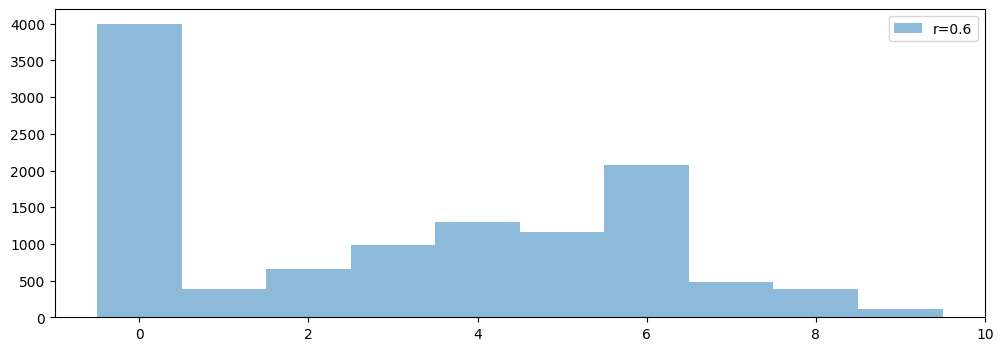

In [31]:
fig,ax = plt.subplots(figsize=(12,4))
#h_counts = ax.hist(counts_01, bins=np.arange(-0.5, 10.5, 1), alpha=0.5, label='r=0.1')
#h_counts = ax.hist(counts_03, bins=np.arange(-0.5, 10.5, 1), alpha=0.5, label='r=0.3')
h_counts = ax.hist(counts_06-counts_03, bins=np.arange(-0.5, 10.5, 1), alpha=0.5, label='r=0.6')
ax.legend()


(-9.0, 8.0)

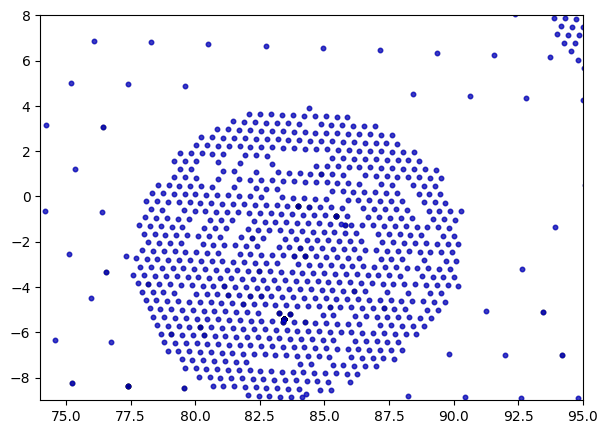

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(points[:, 0], points[:, 1], s=10, c='k', alpha=0.5, label='Data')
ax.scatter(points[:, 0][unique_mask], points[:, 1][unique_mask], s=10, c='b', alpha=0.5, label='Data')
#ax.scatter(points[:, 0][out], points[:, 1][out], s=10, c='r', alpha=0.5, label='Data')

#offset_x = 0.41
#offset_y = offset_x 
#ax.scatter(points[:, 0]+0.5*offset_x, points[:, 1]+0.5*offset_x*np.tan(np.deg2rad(60)), s=5, c='orange', alpha=1.0, marker='+',label='Data')

#ax.scatter(points[:, 0][~out], points[:, 1][~out], s=10, c='blue', alpha=0.5, label='Data')
#ax.scatter(centers[:, 0], centers[:, 1], s=20, c='r', alpha=0.3, label='Hex Centers')
#ax.scatter(centers[:, 0][~out], centers[:, 1][~out], s=20, c='blue', alpha=1.0, label='Hex Centers')
ax.set_xlim(74,95)
#ax.set_xlim(120,160)
ax.set_ylim(-9,8)
#ax.hist(dist, bins=1000)


In [33]:
import astropy.units as u

# pointings having at least 2 other pointings within 30 arcmin
coords = SkyCoord(ra=t['ra'] * u.deg, dec=t['dec'] * u.deg, frame='icrs')
i, j, sep2d, _ = coords.search_around_sky(coords, 50 * u.arcmin)

# remove self-matches, then count neighbors per pointing
valid = i != j
n_neighbors = np.bincount(i[valid], minlength=len(t))

mask_two_others_30arcmin = n_neighbors >= 2

print(f"Masked pointings: {mask_two_others_30arcmin.sum()} / {len(t)}")

# optional filtered table
t_unmasked = t[~mask_two_others_30arcmin]

# if you want this applied to DR20 selection too:
# mask_DR20 &= ~mask_two_others_30arcmin

Masked pointings: 12653 / 15064


156


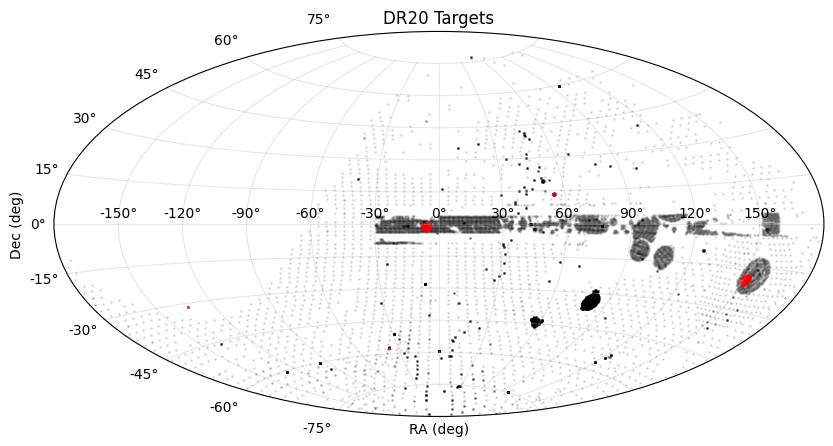

In [34]:
#

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': 'aitoff'})
ax.grid(True, alpha=0.3)

# keep downstream scatter calls in degrees; convert to radians for Aitoff
_scatter = ax.scatter
ax.scatter = lambda lon_deg, lat_deg, *args, **kwargs: _scatter(
    np.radians((-1)*lon_deg), np.radians(lat_deg), *args, **kwargs
)
import astropy.units as u

# keep original ICRS values if this cell is re-run
if 'ra_icrs' not in t.colnames:
    t['ra_icrs'] = t['ra']
    t['dec_icrs'] = t['dec']
    t_DR20['ra_icrs'] = t_DR20['ra']
    t_DR20['dec_icrs'] = t_DR20['dec']

c_icrs = SkyCoord(ra=t['ra_icrs'] * u.deg, dec=t['dec_icrs'] * u.deg, frame='icrs')
c_gal = c_icrs.galactic

# reuse ra/dec fields for plotting with existing scatter lines
t['ra_g'] = c_gal.l.wrap_at(180 * u.deg).deg
t['dec_g'] = c_gal.b.deg
t_DR20 = t[mask_DR20]
print(len(t_DR20))
ax.scatter(t['ra_g'], t['dec_g'], s=1, c='k', alpha=0.1)
ax.scatter(t_DR20['ra_g'], t_DR20['dec_g'], s=1, c='r', alpha=0.5)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DR20 Targets')
#ax.set_xlim(360,0)
plt.show()

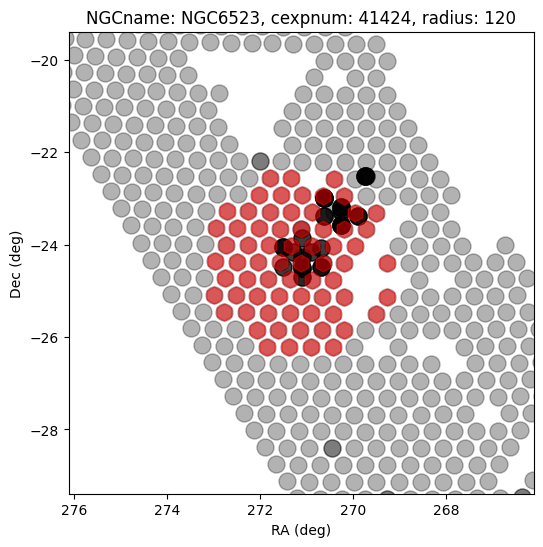

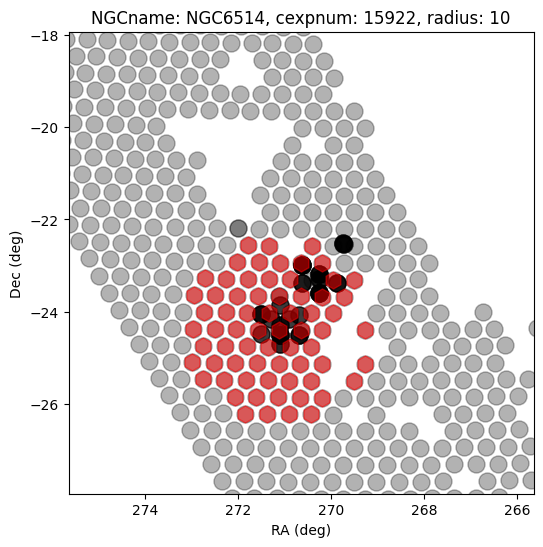

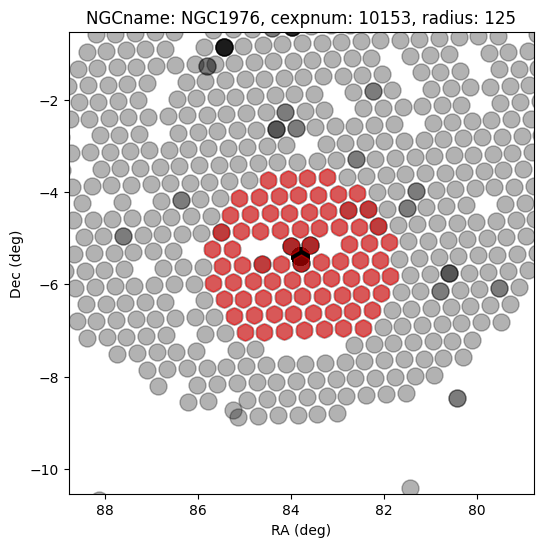

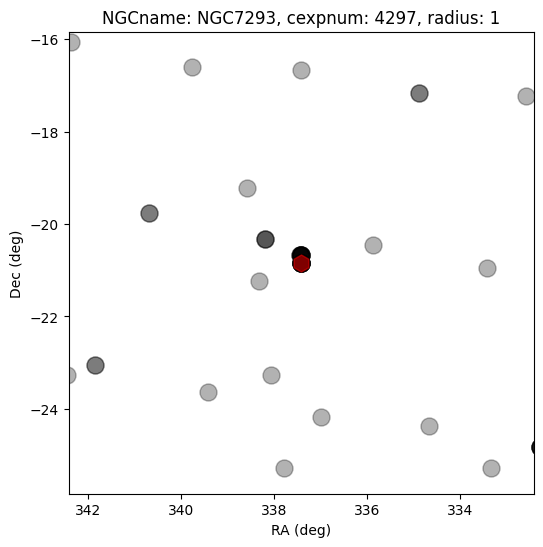

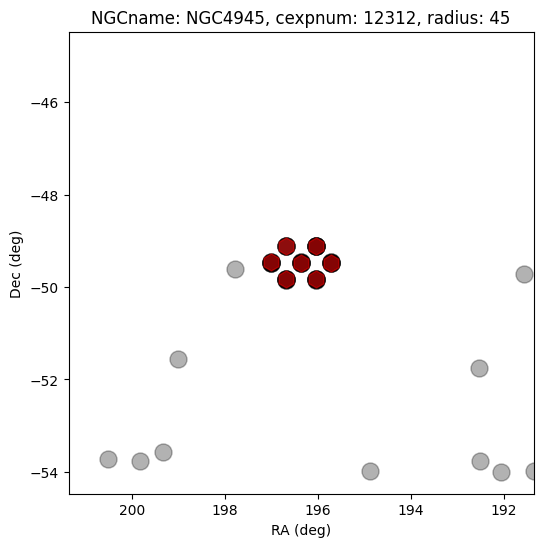

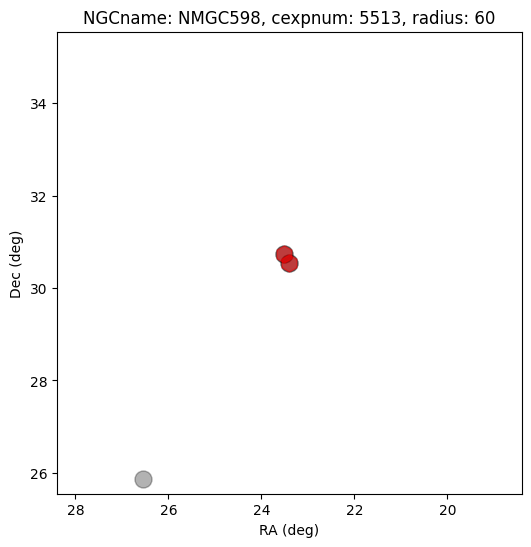

In [37]:
#t_DR20_final = t[mask_DR20]

mask_DR20_final = mask_DR20.copy()
#mask_DR20_final = mask_DR20_final ^ ~unique_mask
#mask_DR20_final = mask_DR20_final & mask_DR20

for I,t_sel_now in enumerate(t_tmp):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(t['ra'], t['dec'], s=150, c='k', alpha=0.3)

    mask_loc_r = np.sqrt((t['ra']-t_sel_now['ra'])**2 + (t['dec']-t_sel_now['dec'])**2) > t_sel_now['radius']/60

    mask_loc = np.sqrt((t['ra']-t_sel_now['ra'])**2 + (t['dec']-t_sel_now['dec'])**2) < 4
    mask_DR20_final[mask_loc] = (mask_DR20_final & ~out)[mask_loc] 




    mask_loc_point = np.sqrt((t['ra']-271.3)**2 + (t['dec']-(-24))**2) < 0.1
    mask_DR20_final[mask_loc_point] = True
#    mask_loc_point = np.sqrt((t['ra']-270.5)**2 + (t['dec']-(-23.25))**2) < 0.1
#    mask_DR20_final[mask_loc_point] = True
#    mask_loc_point = np.sqrt((t['ra']-84.5)**2 + (t['dec']-(-5.5))**2) < 0.4
#    mask_DR20_final[mask_loc_point] = True

#    if (t_sel_now['NGCname'] == 'NGC224'):

    mask_NGCname = (t['NGCname'] == t_sel_now['NGCname'])
    mask_DR20_final[mask_loc_r & mask_NGCname] = False

    if ((t_sel_now['NGCname'] == 'NGC7293') | (t_sel_now['NGCname'] == 'NGC4945')):
        mask_DR20_final[mask_loc] = mask_DR20[mask_loc] 

        
    ax.scatter(t['ra'][mask_DR20_final], t['dec'][mask_DR20_final], s=150, c='r', marker='h', alpha=0.5)


    #ax.scatter(t['ra'][mask_match], t['dec'][mask_match], s=15, c='green', alpha=0.3)

    #ax.scatter(t['ra'][unique_mask], t['dec'][unique_mask], s=150, c='orange', alpha=0.3)

    #ax.scatter(t['ra'][unique_mask][out_u], t['dec'][unique_mask][out_u], s=15, c='b', marker='h', alpha=0.5)
    #ax.scatter(t['ra'][unique_mask][~out_u], t['dec'][unique_mask][~out_u], s=150, c='r', marker='h', alpha=0.5)
#    offset_x = 0.41
    #ax.scatter(t['ra'][~unique_mask], t['dec'][~unique_mask], s=5, c='orange', alpha=1.0, marker='+',label='Data')
#    ax.scatter(t['ra']+offset_x/np.cos(np.deg2rad(t['dec'])), t['dec'], s=5, c='orange', alpha=1.0, marker='+',label='Data')
    #ax.scatter(centers[:, 0], centers[:, 1], s=20, c='r', alpha=0.3, label='Hex Centers')
#    ax.scatter(t_DR20['ra'][~mask_two_others_30arcmin_DR20], t_DR20['dec'][~mask_two_others_30arcmin_DR20], s=150, c='r', marker='h', alpha=0.5)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_xlim(t_sel_now['ra'] + 5, t_sel_now['ra'] - 5)
    ax.set_ylim(t_sel_now['dec'] - 5, t_sel_now['dec'] + 5)
    ax.set_title(f"NGCname: {t_sel_now['NGCname']}, cexpnum: {t_sel_now['cexpnum']}, radius: {t_sel_now['radius']}")

In [38]:
t[mask_DR20_final]

tilegrp,tileid,mjd,expnum,exptime,stage,status,drpqual,drpver,dpos,object,obstime,std_mean_senb,std_mean_senr,std_mean_senz,sci_mean_senb,sci_mean_senr,sci_mean_senz,mod_mean_senb,mod_mean_senr,mod_mean_senz,fluxcal,sci_ra,sci_dec,sci_pa,sci_amass,sci_kmpos,sci_focpos,sci_alt,sci_sh_hght,sci_moon_sep,skye_ra,skye_dec,skye_pa,skye_amass,skye_kmpos,skye_focpos,skye_name,skye_alt,sci_skye_sep,skye_sh_hght,skye_moon_sep,skyw_ra,skyw_dec,skyw_pa,skyw_amass,skyw_kmpos,skyw_focpos,skyw_name,skyw_alt,sci_skyw_sep,skyw_sh_hght,skyw_moon_sep,moon_ra,moon_dec,moon_phase,moon_fli,sun_alt,moon_alt,filename,location,agcam_location,calib_mjd,ra,dec,pa,NGCname,ra_icrs,dec_icrs,ra_g,dec_g
bytes6,int64,int64,int64,float64,int64,int64,int64,bytes5,int64,bytes59,bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes23,bytes77,bytes65,int64,float64,float64,float64,object,float64,float64,float64,float64
0011XX,11111,60181,3728,60.0,1,0,0,1.2.0,0,--,2023-08-25T04:08:27.294,6.5259829436348e-14,3.30773069236845e-14,2.2334569267887e-14,9.19469243446659e-14,3.37117565243108e-14,2.33794156930661e-14,6.58053141905162e-14,3.29430974347982e-14,2.23958492894714e-14,SCI,337.410625,-20.837111,0.0,1.033,-50.98,36.03,75.4888,24300.62414,81.0249,321.613,-44.5432,0.0,1.038,-51.67,35.54,None,74.4367,27.0688,7093.90816,61.4439,333.511643,-23.250798,0.0,1.016,-49.12,36.37,None,79.8261,4.3455,19655.59968,76.7564,247.68765,-25.28263,98.47,0.5748,-69.9336,23.0426,lvmSFrame-00003728.fits,sdsswork/lvm/spectro/redux/1.2.0/0011XX/11111/60181/lvmSFrame-00003728.fits,sdsswork/data/agcam/lco/60181/coadds/lvm.sci.coadd_s00003728.fits,60177,337.410625,-20.837111,0.0,NGC7293,337.410625,-20.837111,36.16141839427528,-57.11837784310887
0011XX,11111,60212,5511,900.0,1,0,0,1.2.0,0,M33low,2023-09-25T05:06:15.072,5.93364104499617e-14,3.0075870160765e-14,2.04362739657837e-14,1.77160225523789e-14,8.68803838650601e-15,5.70720655962996e-15,5.98242122230226e-14,3.00970485910605e-14,2.04658173981203e-14,MOD,23.39818229004826,30.54888219142393,-0.13527164844496628,2.072,-35.19,35.86,28.8218,11226.20684,92.2859,15.656696570206297,26.31406614505264,0.7110958729923272,1.774,-25.74,35.54,None,34.2101,8.014,15112.70013,84.2831,2.061657384431092,-34.65171483442845,0.8829175284037336,1.011,-43.48,36.53,None,81.729,68.2297,5378.71818,49.4528,305.80618,-24.23374,120.69,0.7561,-59.2906,33.695,lvmSFrame-00005511.fits,sdsswork/lvm/spectro/redux/1.2.0/0011XX/11111/60212/lvmSFrame-00005511.fits,sdsswork/data/agcam/lco/60212/coadds/lvm.sci.coadd_s00005511.fits,60177,23.39818229004826,30.54888219142393,-0.13527164844496628,NMGC598,23.39818229004826,30.54888219142393,133.5719037786825,-31.450434227404184
0011XX,11111,60212,5512,900.0,1,0,0,1.2.0,0,M33up,2023-09-25T05:25:45.401,6.00715737588717e-14,3.03991426821769e-14,2.06346652533581e-14,4.92902554021389e-14,2.743663527711e-14,1.7655788074442e-14,6.06460421515242e-14,3.05751377774704e-14,2.06837468901422e-14,MOD,23.518731309869295,30.729483505260426,-0.10601865142333082,2.03,-28.9,35.64,29.4781,10554.07581,92.2832,15.656702697400602,26.3140256502294,0.71438010568845,1.761,-19.7,35.54,None,34.5255,8.1947,14402.26503,84.1059,21.018611554026393,-22.927009187961154,0.8522601861952864,1.012,-47.21,36.43,None,81.2975,53.7101,5937.12904,67.8884,305.98274,-24.15686,120.85,0.7573,-57.8181,29.6356,lvmSFrame-00005512.fits,sdsswork/lvm/spectro/redux/1.2.0/0011XX/11111/60212/lvmSFrame-00005512.fits,sdsswork/data/agcam/lco/60212/coadds/lvm.sci.coadd_s00005512.fits,60177,23.518731309869295,30.729483505260426,-0.10601865142333082,NMGC598,23.518731309869295,30.729483505260426,133.650566891124,-31.253300300343422
1028XX,1028592,60226,6374,900.0,1,0,

In [39]:
print(len(t[mask_DR20_final]))

156


In [40]:
t_DR20_final = t[mask_DR20_final]
t_DR20_final.write("tables/dr20_pointings_final.csv", format="ascii.csv",delimiter=",",overwrite=True)

In [48]:
out_file = "tables/dr20_paths.txt"
mode = "w" if I == 0 else "a"

for I,t_now in enumerate(t_DR20_final):
    tilegrp = t_now['tilegrp']
    expnum = f"{int(t_now['expnum']):08d}"
    tileid = t_now['tileid']
    mjd = t_now['mjd']
    with open(out_file, mode) as f:
        print(
            f"/mnt/NASfilemon/LVM/sdsswork/analysis/LVMDAP/{DRPVER}/{tilegrp}/{tileid}/{mjd}/{expnum}/",
            file=f
        )
